In [2]:
import pandas as pd

df = pd.read_excel('../data/DU LAW REQUEST.XLSX')

In [84]:
df['unhoused'] = df['CURRENT_STREET_ADDRESS'] != 'YES' # The court told us that housed people were listed as "YES"

In [85]:
df.head()

,COURT_CASE,VIOLATION_DATE,CURRENT_STREET_ADDRESS,STATUTE_DESC,STATUE_NUMBER,LOCATION,unhoused
0,CR-2015-0000038-GE,2015-01-04 04:50:00,YES,Trespassing,5-4-3,2900 IRIS,False
1,CR-2015-0000042-GE,2015-01-04 15:40:00,NONE,Trespassing,5-4-3,1800 28TH ST (MCDONALDS),True
2,CR-2015-0000046-GE,2015-01-03 23:58:00,YES,Trespassing,5-4-3,1905 15TH ST,False
3,CR-2015-0000047-GE,2015-01-01 15:43:00,2960 VALMONT RD,Trespassing,5-4-3,3255 28TH ST,True
4,CR-2015-0000061-GE,2015-01-01 20:05:00,NONE,Trespassing,5-4-3,1650 30TH ST,True


In [86]:
print('''There are {} rows. The date range is {:%Y-%m-%d} to {:%Y-%m-%d}.

There are {} unique "court cases".

{} out of {} citations are for unhoused.
'''.format(
        df.shape[0],
        df.VIOLATION_DATE.min(),
        df.VIOLATION_DATE.max(),
        df.COURT_CASE.nunique(),
        df.unhoused.sum(), df.shape[0]
))

There are 4568 rows. The date range is 2015-01-01 to 2017-12-30.

There are 3854 unique "court cases".

3149 out of 4568 citations are for unhoused.



In [108]:
df_housed = df[~df.unhoused]
df_unhoused = df[df.unhoused]

In [109]:
all_statute_counts = df.STATUTE_DESC.value_counts().to_frame()
housed_statute_counts = df_housed.STATUTE_DESC.value_counts().to_frame()
unhoused_statute_counts = df_unhoused.STATUTE_DESC.value_counts().to_frame()

1. Can we find the number of charges that aren't bundled with other ones?
2. Which of sets of citations tend to go together?

In [110]:
# create a dataframe with only the citations that were given independently

onesies = df.groupby('COURT_CASE').first()[df.groupby('COURT_CASE').count().VIOLATION_DATE == 1].reset_index()
onesies_housed = df_housed.groupby('COURT_CASE').first()[df_housed.groupby('COURT_CASE').count().VIOLATION_DATE == 1].reset_index()
onesies_unhoused = df_unhoused.groupby('COURT_CASE').first()[df_unhoused.groupby('COURT_CASE').count().VIOLATION_DATE == 1].reset_index()

In [112]:
onesie_charges_merged = pd.merge(onesies.STATUTE_DESC.value_counts().to_frame(), all_statute_counts, how='inner', left_index=True, right_index=True, suffixes=('_onesies', '_all')).fillna(0).rename(columns={
        'STATUTE_DESC_onesies': 'count_onesies',
        'STATUTE_DESC_all': 'count_all',
    })
onesie_charges_merged['proportion_onesies'] = onesie_charges_merged['count_onesies'] / onesie_charges_merged['count_all']

housed_onesie_charges_merged = pd.merge(onesies_housed.STATUTE_DESC.value_counts().to_frame(), housed_statute_counts, how='inner', left_index=True, right_index=True, suffixes=('_onesies', '_all')).fillna(0).rename(columns={
        'STATUTE_DESC_onesies': 'count_onesies',
        'STATUTE_DESC_all': 'count_all',
    })
housed_onesie_charges_merged['proportion_onesies'] = housed_onesie_charges_merged['count_onesies'] / housed_onesie_charges_merged['count_all']

unhoused_onesie_charges_merged = pd.merge(onesies_unhoused.STATUTE_DESC.value_counts().to_frame(), unhoused_statute_counts, how='inner', left_index=True, right_index=True, suffixes=('_onesies', '_all')).fillna(0).rename(columns={
        'STATUTE_DESC_onesies': 'count_onesies',
        'STATUTE_DESC_all': 'count_all',
    })
unhoused_onesie_charges_merged['proportion_onesies'] = unhoused_onesie_charges_merged['count_onesies'] / unhoused_onesie_charges_merged['count_all']

In [67]:
onesie_charges_merged

,count_onesies,count_all,proportion_onesies
Trespassing,1252,1564,0.800512
Smoking Prohibited in Public Areas,901,969,0.929825
Camping or Lodging on Property Without Consent,746,916,0.814410
Urinating in Public,251,347,0.723343
Tents And Nets Prohibited,82,104,0.788462
Trespassing on Public Property,20,28,0.714286
Staying on Medians Prohibited,11,12,0.916667
Using a Vehicle as a Residence,9,11,0.818182
Aggressive Begging Prohibited,6,8,0.750000
"Obstructing Public Streets, Places - Buildings",3,6,0.500000


In [53]:
antihomeless_statutes = onesie_charges_merged.index.tolist()

In [115]:
only_antihomeless_encounters = df.groupby('COURT_CASE').filter(
    lambda case: case.STATUTE_DESC.isin(antihomeless_statutes).all()
)

only_antihomeless_encounters_housed = df_housed.groupby('COURT_CASE').filter(
    lambda case: case.STATUTE_DESC.isin(antihomeless_statutes).all()
)

only_antihomeless_encounters_unhoused = df_unhoused.groupby('COURT_CASE').filter(
    lambda case: case.STATUTE_DESC.isin(antihomeless_statutes).all()
)

print('''If we ask for encounters where someone was only given ONE citation (no matter what it is), we get {} records.

But if we ask for encounters where all the citations were antihomeless, we get {} records.

(Out of {} total unique encounters).
'''.format(
        onesies.shape[0],
        only_antihomeless_encounters.shape[0],
        df.COURT_CASE.nunique()
    ))



If we ask for encounters where someone was only given ONE citation (no matter what it is), we get 3281 records.

But if we ask for encounters where all the citations were antihomeless, we get 3451 records.

(Out of 3854 total unique encounters).



In [116]:
total_count_antihomeless = only_antihomeless_encounters.groupby('STATUTE_DESC').COURT_CASE.count()
housed_count_antihomeless = only_antihomeless_encounters_housed.groupby('STATUTE_DESC').COURT_CASE.count()
unhoused_count_antihomeless = only_antihomeless_encounters_unhoused.groupby('STATUTE_DESC').COURT_CASE.count()

In [121]:
housed_antihomeless_charges_merged = pd.merge(housed_statute_counts, only_antihomeless_encounters_housed.STATUTE_DESC.value_counts().to_frame(), how='inner', left_index=True, right_index=True, suffixes=('_all', '_antihomeless')).fillna(0).rename(columns={
        'STATUTE_DESC_antihomeless': 'count_antihomeless',
        'STATUTE_DESC_all': 'count_all',
    })
housed_antihomeless_charges_merged['count_onesies'] = housed_onesie_charges_merged['count_onesies']
housed_antihomeless_charges_merged['proportion_antihomeless'] = housed_antihomeless_charges_merged['count_antihomeless'] / housed_antihomeless_charges_merged['count_all']
housed_antihomeless_charges_merged['proportion_onesies'] = housed_onesie_charges_merged['proportion_onesies']

housed_antihomeless_charges_merged

,count_all,count_antihomeless,count_onesies,proportion_antihomeless,proportion_onesies
Trespassing,469,382,374,0.814499,0.797441
Urinating in Public,253,187,185,0.739130,0.731225
Smoking Prohibited in Public Areas,247,223,220,0.902834,0.890688
Camping or Lodging on Property Without Consent,159,141,133,0.886792,0.836478
Tents And Nets Prohibited,38,35,32,0.921053,0.842105
Trespassing on Public Property,4,4,4,1.000000,1.000000
Staying on Medians Prohibited,1,1,1,1.000000,1.000000
Using a Vehicle as a Residence,1,1,1,1.000000,1.000000


In [123]:
unhoused_antihomeless_charges_merged = pd.merge(unhoused_statute_counts, only_antihomeless_encounters_unhoused.STATUTE_DESC.value_counts().to_frame(), how='inner', left_index=True,            right_index=True, suffixes=('_all', '_antihomeless')).fillna(0).rename(columns={
        'STATUTE_DESC_antihomeless': 'count_antihomeless',
        'STATUTE_DESC_all': 'count_all',
    })
unhoused_antihomeless_charges_merged['count_onesies'] = unhoused_onesie_charges_merged['count_onesies']
unhoused_antihomeless_charges_merged['proportion_antihomeless'] = unhoused_antihomeless_charges_merged['count_antihomeless'] / unhoused_antihomeless_charges_merged['count_all']
unhoused_antihomeless_charges_merged['proportion_onesies'] = unhoused_onesie_charges_merged['proportion_onesies']

unhoused_antihomeless_charges_merged

,count_all,count_antihomeless,count_onesies,proportion_antihomeless,proportion_onesies
Trespassing,1095,942,878,0.860274,0.801826
Camping or Lodging on Property Without Consent,757,674,613,0.890357,0.809775
Smoking Prohibited in Public Areas,722,685,681,0.948753,0.943213
Urinating in Public,94,73,66,0.776596,0.702128
Tents And Nets Prohibited,66,56,50,0.848485,0.757576
Trespassing on Public Property,24,19,16,0.791667,0.666667
Staying on Medians Prohibited,11,11,10,1.000000,0.909091
Using a Vehicle as a Residence,10,8,8,0.800000,0.800000
Aggressive Begging Prohibited,8,6,6,0.750000,0.750000
"Obstructing Public Streets, Places - Buildings",5,3,3,0.600000,0.600000


In [117]:
antihomeless_charges_merged = pd.merge(all_statute_counts, only_antihomeless_encounters.STATUTE_DESC.value_counts().to_frame(), how='inner', left_index=True, right_index=True, suffixes=('_all', '_antihomeless')).fillna(0).rename(columns={
        'STATUTE_DESC_antihomeless': 'count_antihomeless',
        'STATUTE_DESC_all': 'count_all',
    })
antihomeless_charges_merged['count_onesies'] = onesie_charges_merged['count_onesies']
antihomeless_charges_merged['proportion_antihomeless'] = antihomeless_charges_merged['count_antihomeless'] / antihomeless_charges_merged['count_all']
antihomeless_charges_merged['proportion_onesies'] = onesie_charges_merged['proportion_onesies']

antihomeless_charges_merged

,count_all,count_antihomeless,count_onesies,proportion_antihomeless,proportion_onesies
Trespassing,1564,1324,1252,0.846547,0.800512
Smoking Prohibited in Public Areas,969,908,901,0.937049,0.929825
Camping or Lodging on Property Without Consent,916,815,746,0.889738,0.814410
Urinating in Public,347,260,251,0.749280,0.723343
Tents And Nets Prohibited,104,91,82,0.875000,0.788462
Trespassing on Public Property,28,23,20,0.821429,0.714286
Staying on Medians Prohibited,12,12,11,1.000000,0.916667
Using a Vehicle as a Residence,11,9,9,0.818182,0.818182
Aggressive Begging Prohibited,8,6,6,0.750000,0.750000
"Obstructing Public Streets, Places - Buildings",6,3,3,0.500000,0.500000


## Plotting citations by month

In [81]:
%matplotlib inline

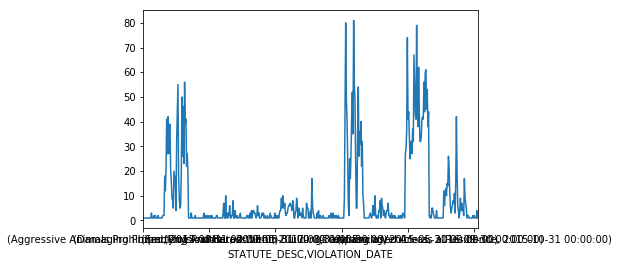

In [82]:
df.groupby([df.STATUTE_DESC, pd.Grouper(key='VIOLATION_DATE', freq='M')]).count().COURT_CASE.plot()

In [75]:
df.VIOLATION_DATE.iloc[0]

Timestamp('2015-01-04 04:50:00')